This code was written attempting to use a different approach, the maximum likelihood fitting, to replicate the harmonic potential analysis done by Hank Ashbaugh and Alireza Hosseni, who used least-squares fitting. Equations and variables are referenced from their article in the following link: https://pubs.acs.org/doi/10.1021/acs.jctc.3c00982

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize
from scipy.integrate import simpson
import pickle
import pdb
import os.path
import MDAnalysis as mda
from scipy.integrate import quad, simpson, trapezoid
from timeit import default_timer as timer

# Defining variables and constants

Parameters to define before analysis

In [2]:
N_i = 217 #Number of ions used
k = 0.68095403  # units: kJ/mol/nm^2 - force constant being used in calculations

L_x, L_y, L_z = 4.8, 4.8, 14.4  # lengths in x,y and z caluations
T = 300  # units: K - temperature used for calculations

Constants

In [3]:
NA = 6.02214076E23  # Avogadro's number
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant

# Calculating eq 12

$$ ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [4]:
A = 1.7964  # in M^(-1/2), value based on Debye Huckel equations.

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

In [5]:
def calc_y(theta, x):
    '''
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    '''

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

# Importing input data

Input file directory

In [ ]:
traj_dir = '../osmotic_calculations_trajs/HP'
# traj_dir = '.'

Note: OpenMM code outputs dcd trajectory files, which where converted to xtc using the package mdtraj's function mdconvert since mdanalysis does not read the dcd files correctly and brings out errors.

In [7]:
us = list()
ions = list()
for i in range(4):
    pdb = 'mdr'+str(i)+'.pdb'
    xtc = 'mdr'+str(i)+'.xtc'
    u = mda.Universe(pdb, os.path.join(traj_dir,xtc))
    u.transfer_to_memory()
    us.append(u)
    ions.append(u.select_atoms('resname NA CL'))

In [8]:
def get_ion_array(u,ions):
    '''
    Function to get array of ion's z coordinate positions throughout trajectory of all samples.
    '''
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data, setting the half of the length of the box to zero
    zvals=ionz.flatten()
    return zvals

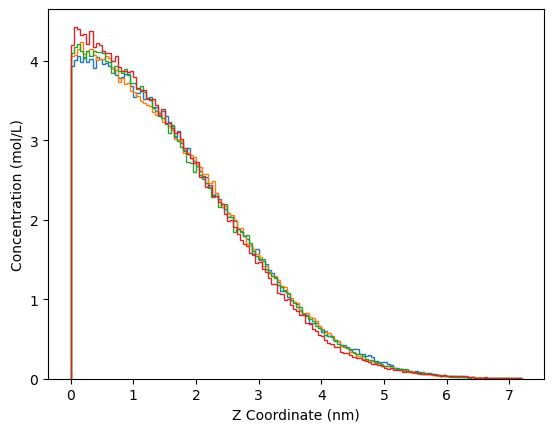

In [9]:
zvals = []
concentration_profiles = []
z = []

# Loop through replicates to get ion coordinates
for i in range(4):
    zvals_i = get_ion_array(us[i], ions[i])
    zvals.append(zvals_i)
    
    # Calculate histogram to get concentration profiles
    concs, bins, _ = plt.hist(
        zvals_i, 
        bins=144, 
        weights=np.full_like(zvals_i, N_i / zvals_i.size), 
        histtype='step'
    )
    concentration_profiles.append(concs)
    z.append(bins[1:])  # Exclude the first bin edge for z-coordinates

    plt.xlabel('Z Coordinate (nm)')
    plt.ylabel('Concentration (mol/L)')

# Convert to NumPy arrays
concentration_profiles = np.array(concentration_profiles)
z = np.array(z)

# Calculate the mean of replicates for z coordinates
z_mean = np.mean(z, axis=0)

# Compile all ion arrays into one for use in maximum likelihood approximation
zvals_all=np.array(zvals).flatten()

In [10]:
for i,c in enumerate(concentration_profiles):
    N_s = L_x * L_y * simpson(y=c, x=z_mean)
    print('%i'% N_s)  # compare to number of ions used (3m used 217)

# compare to number of ions used
print(f'Number of ions used: {N_i}')

247
247
247
247
Number of ions used: 217


In [11]:
#Use the direct average rather than over bootstrap means
c_0 = np.mean(concentration_profiles,axis=0)

# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z_mean[c_0 != 0]
c_fit = c_0[c_0 != 0]

# Approximation by Histograms - Least squares fitting

## Unweighted least squares fitting

In [12]:
# Right side/ y of equation 12
y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T) 

#Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

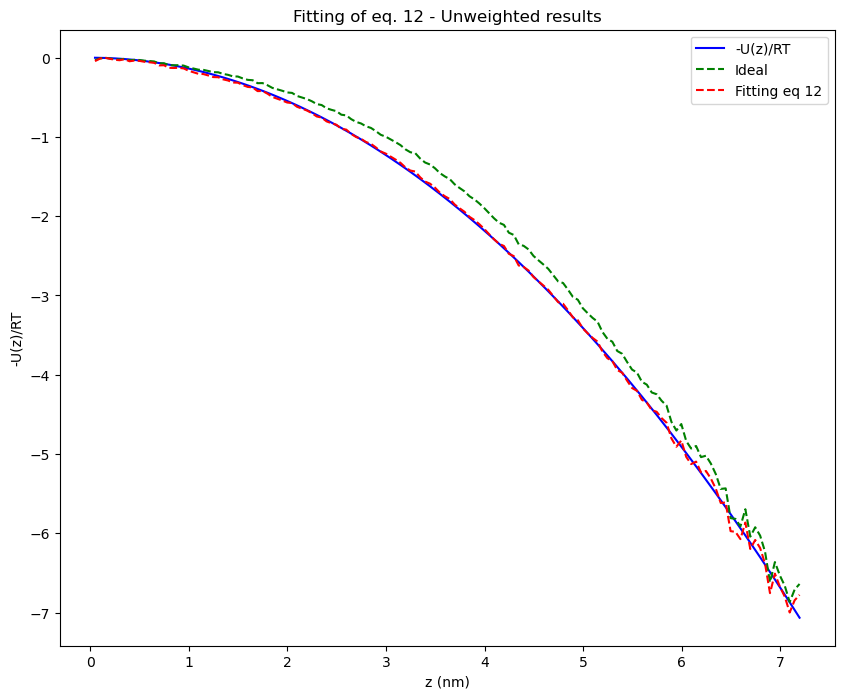

In [13]:
# plot the unweighted results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Unweighted results')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $|f'(x)| \delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

## Weighted least squares fitting

In [14]:
## Finding weights 
norm = N_s/(L_x*L_y)
print(norm)

def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(np.subtract(calc_y(theta, x),y), 2)

10.728792712475355


In [15]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

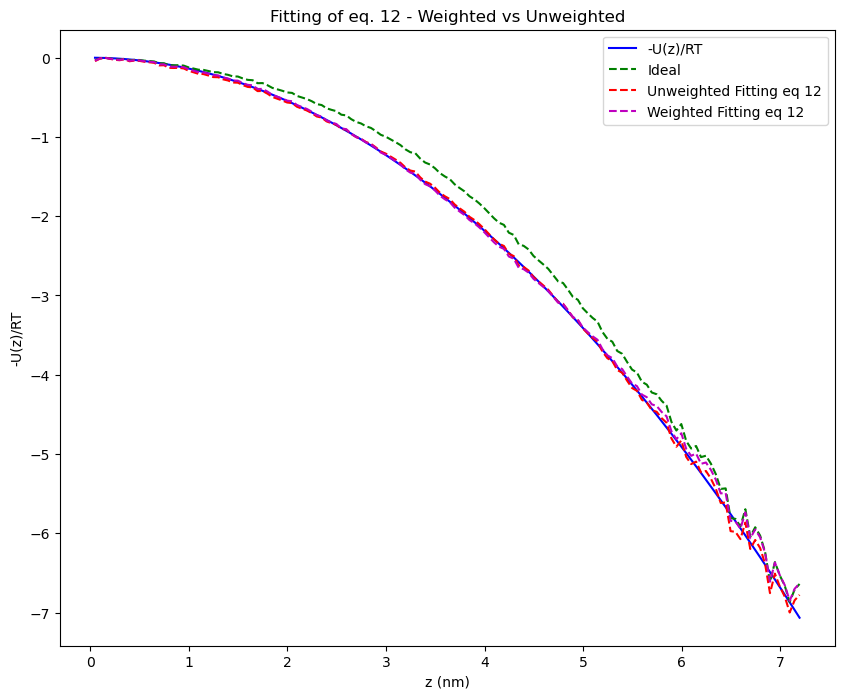

In [16]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 - Weighted vs Unweighted')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

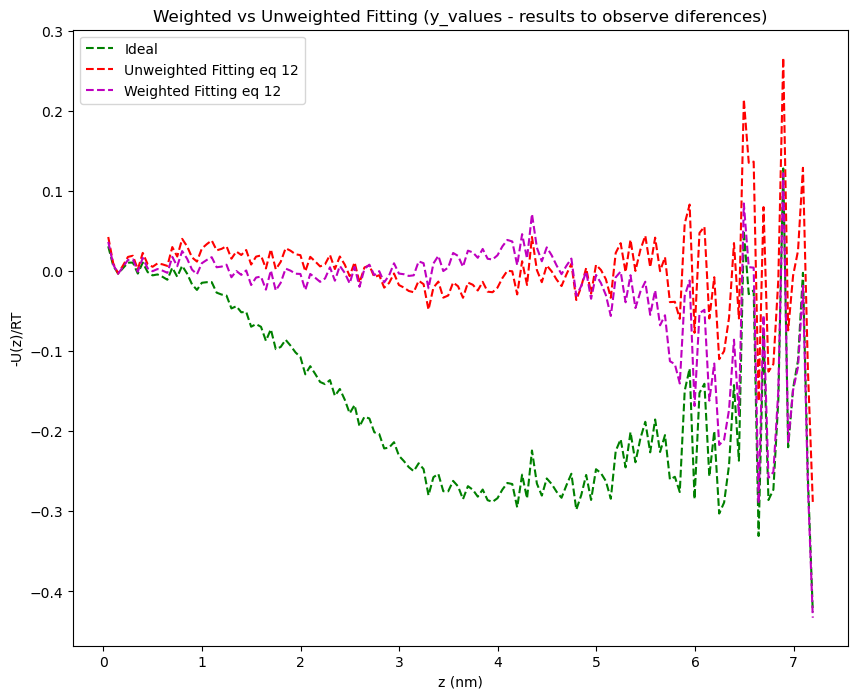

In [17]:
# plot the results. Notice the plots are now being subtracted from the y_values results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Weighted vs Unweighted Fitting (y_values - results to observe diferences)')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [18]:
zlim = 4 #coordinate limit for where fitting is closer

#Stdev of unweighted results
stdev_uw = np.std(y_values[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of unweighted results: {stdev_uw}')

#Stdev of weighted results
stdev_w = np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))
print(f'Stdev of weighted results: {stdev_w}')

Stdev of unweighted results: 0.020226703189294974
Stdev of weighted results: 0.012649996402921646


Compare the distribution of the parameters with the fit!

In [19]:
print('--- UNWEIGHTED PARAMETERS ---')
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

print('--- WEIGHTED PARAMETERS ---')
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

--- UNWEIGHTED PARAMETERS ---
B = 4.31541637950866
alpha1 = 0.0726549479666674
alpha2 = 0.0024990628895057688
--- WEIGHTED PARAMETERS ---
B = 1.19090868915969
alpha1 = 0.27741311994641954
alpha2 = -0.024690982413597327


## Bootstrapping Profiles (without and with weights)

In [20]:
trialp = [4, 0.1,0.0]

In [21]:
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z_mean[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Param 0 = 5875.6522486984595 +/- 18484.76787576434


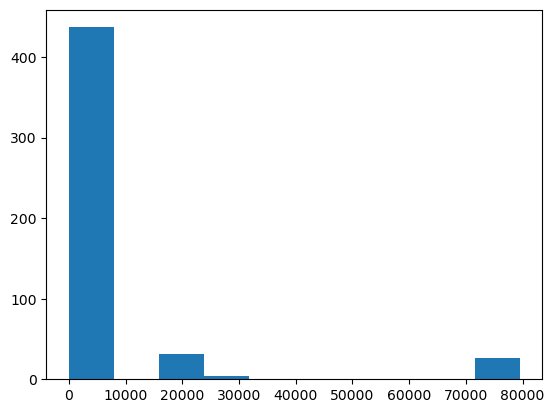

Param 1 = 0.1834954492423417 +/- 0.19606996635575571


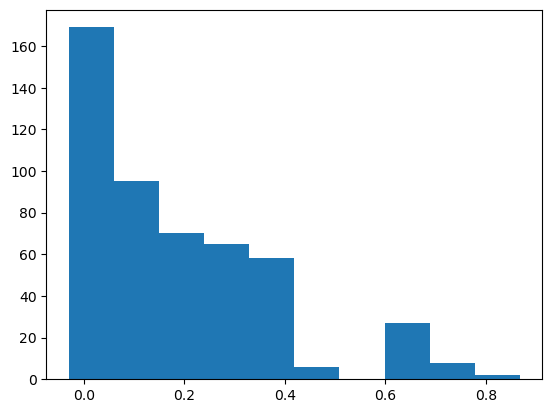

Param 2 = -0.012656093052928277 +/- 0.024521935812078084


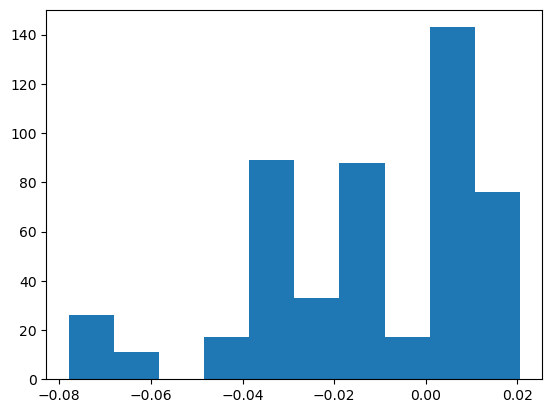

In [22]:
# Perform bootstrapping with unweighted fit
bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=residuals)
uw_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    uw_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Param 0 = 1.3117870479757658 +/- 0.5419198555102721


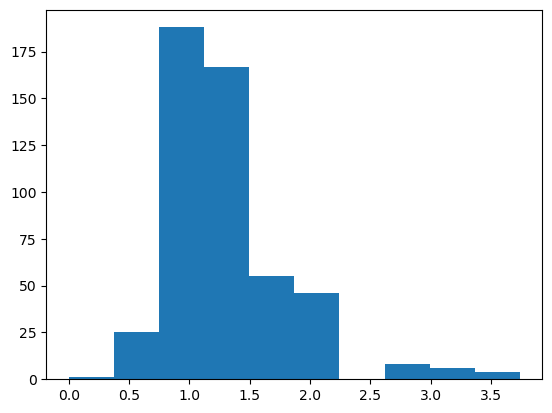

Param 1 = 0.2828165701733151 +/- 0.08396305370288307


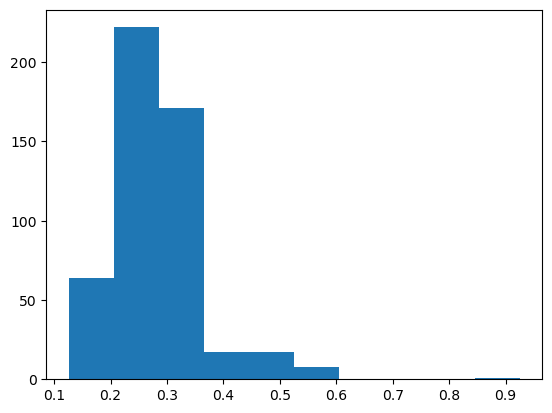

Param 2 = -0.025040839385077538 +/- 0.009604703355235776


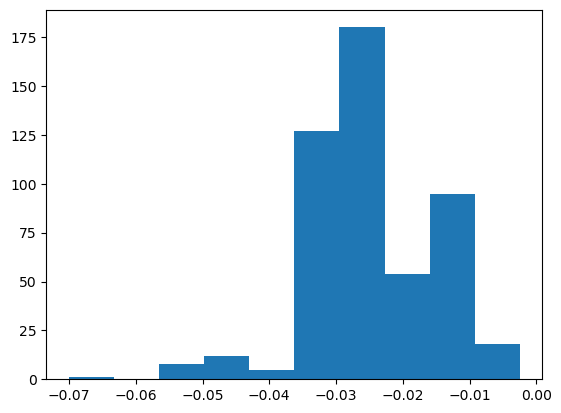

In [23]:
# Perform bootstrapping with weighted residuals
bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=weighted_residuals)
w_bs_params=[]
for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    w_bs_params.append(mean_param)
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

# Maximum Likelihood Parameter Optimization

The basic idea of maximum likelihood parameter optimization is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have

$P(a|x) \propto P(x|a)$.

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

To get a sense of the how many duplicates there are at each z.

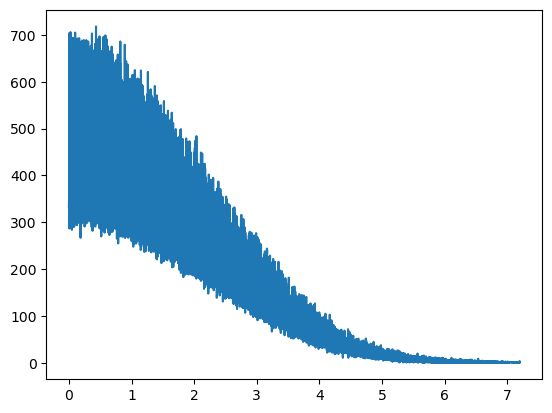

In [24]:
zsparse_o,zcount_o = np.unique(zvals_all,return_counts=True)
plt.plot(zsparse_o,zcount_o)
plt.show()

For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $z$ coordinate, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


## Normalization

Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [25]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

In [26]:
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k)) #analytical solution
print(ideal_norm)

2.398715608911231


In [27]:
cmax_ideal=N_i/(L_x*L_y*ideal_norm)
print(cmax_ideal)

3.92643577370673


### Calculation functions

In [28]:
def logprobfunc(a,z,cz,A=A):
    '''
    Function that calculates maximum concentration.
    '''
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [29]:
def czfunc(a,z,cz):
    '''
    Function that iterates the calculation of a concentration.
    '''
    cznew = np.exp(logprobfunc(a,z,cz))  # exponential of eq 12 for ln c/cmax for the data points
    zunique, locs = np.unique(z,return_index=True)  # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],x = zunique) # integrate
    cznorm_ratio = ideal_norm/newarea # get normalization ratio
    return (cmax_ideal*cznorm_ratio)*cznew

In [30]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):
    '''
    Function that calculates the concentration from given parameters, z coordinate list, starting concentration list.
    '''

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

In [31]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    '''
    Function that calcualtes the logarithm term, arranged as a solution to equation 12, using 
    new generated concentrations from given parameters
    '''
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [32]:
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    '''
    Function to perform bootstrapping over samples
    '''
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

### Fitting

We can use sparse data to make calculation faster since some ion z coordinates repeat multiple times throughout trajectories

In [33]:
newp = np.array([1.35,0.33,-0.04]) # propose initial parameter guesses

In [34]:
zsparse_all, zcount_all = np.unique(zvals_all,return_counts=True) # get sparse data of z coordinate list

In [35]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True) # get concentrations for sparse z coordinate list

0 14.755322
1 1.7385801
2 0.30291596
3 0.05563288
4 0.010703919
5 0.002128535
6 0.00043306913


In [36]:
results = minimize(neglliter,newp,args=(zsparse_all,c_new_sparse_all,zcount_all),method = 'Nelder-Mead') # minimize using sparse data
full_opt=results.x
print(full_opt)

[ 2.04100347  0.18774595 -0.01317116]


In [37]:
c_opt_sparse_all = converge_c(full_opt,zsparse_all,cz_start=c_new_sparse_all,verbose=False) # get conventrations from minimized/optimized parameters

### Bootstrapping

In [38]:
bparams,bcs = bootstrap_samples(zvals_all, 100, neglliter, results.x) # Change number of bootstraps desired, using 500 here

0 [ 2.06132579  0.18266673 -0.01185914] 950952.6204054379
1 [ 2.04902709  0.18615514 -0.01276017] 950466.3503888729
2 [ 2.2878618   0.16517634 -0.00936544] 950214.8092152162
3 [ 2.29062279  0.16799495 -0.01024357] 949803.6316833857
4 [ 2.46522038  0.15541985 -0.00775429] 951404.631839511
5 [ 2.18435576  0.16853101 -0.00953781] 949998.3942427516
6 [ 2.37396873  0.16320525 -0.00914508] 951603.3474855712
7 [ 2.12624399  0.17975336 -0.01199138] 949741.769645977
8 [ 2.10050073  0.17663954 -0.0112239 ] 948908.051231632
9 [ 2.12477787  0.17274763 -0.01017572] 949898.5711396243
10 [ 2.18901391  0.17564405 -0.01133904] 950329.8972366859
11 [ 2.66286427  0.14281437 -0.00563237] 951449.7486594047
12 [ 2.45617898  0.15150675 -0.00679794] 951015.3304862746
13 [ 2.15970495  0.16852886 -0.00964862] 948867.169851778
14 [ 2.26814896  0.16245905 -0.00875366] 949524.7894819453
15 [ 1.98310596  0.18690978 -0.0123172 ] 950655.1214801451
16 [ 2.02743397  0.18004373 -0.01120016] 949869.5224135475
17 [ 2.2827

### Results Statistics

In [39]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.94191789  0.88459521]
 [-0.94191789  1.         -0.98635973]
 [ 0.88459521 -0.98635973  1.        ]]


Parameter 0 = 2.223095937673976 +/- 0.17613280696227537


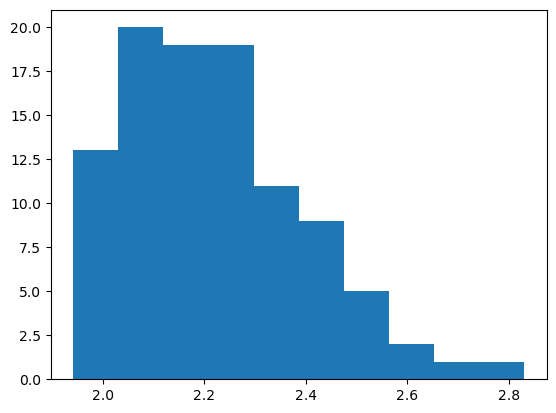

Parameter 1 = 0.17079959717686066 +/- 0.012614651190017553


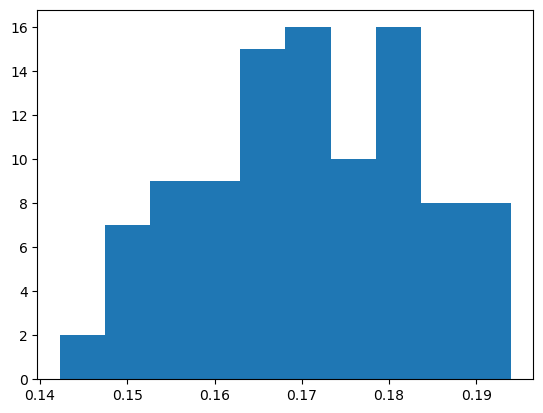

Parameter 2 = -0.010230240818344248 +/- 0.0020677743867586807


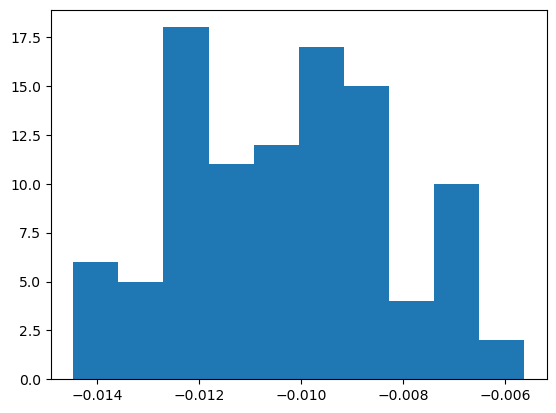

In [40]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parameter {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()


B: parameter 0

$\alpha_1$: parameter 1

$\alpha_2$: parameter 2

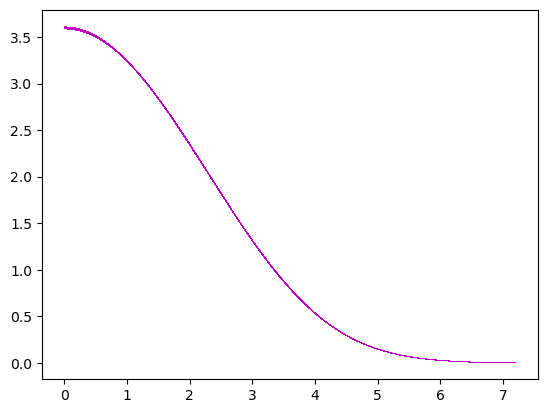

In [41]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse_all,bcs[i],s=0.1,lw=0.1,c='m')
plt.show()

### Calculating osmotic pressure and osmotic coefficients 

In [42]:
def osmotic_pressure(cs, params, nu=2):
    """
    Function to calculate osmotic pressure and osmotic coefficients from the parameters
    """
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4) # osmotic pressure
    op=p/100 # osmotic pressure in units of bar
    ip = nu*R*T*cs  # ideal osmotic pressure
    return op,p/ip # osmotic pressure, osmotic coefficient

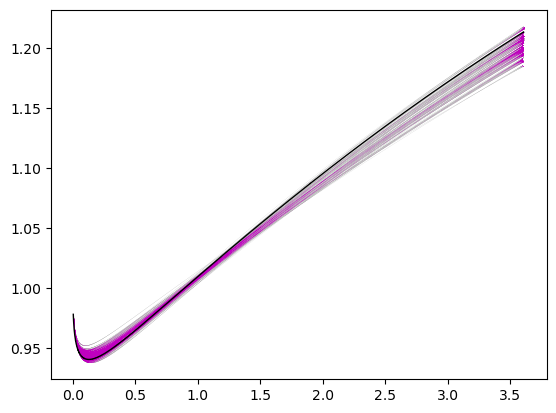

In [43]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse_all,full_opt)[1]
opt_op = osmotic_pressure(c_opt_sparse_all,full_opt)[0]
plt.plot(c_opt_sparse_all,opt_oc,'k',lw=1,alpha=1)
# plt.ylim([0.8,1.2])
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

In [44]:
def find_closest(lst, target):
    '''
    Function that finds the closest index from the concentration list, given a target concentration value
    '''
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    closest_value = lst[closest_index]
    return closest_index, closest_value

In [45]:
# Uncertainty precision options
lower_bound_95_oc = np.percentile(ocs, 2.5, axis=0)
upper_bound_95_oc = np.percentile(ocs, 97.5, axis=0)
lower_bound_95_op = np.percentile(ops, 2.5, axis=0)
upper_bound_95_op = np.percentile(ops, 97.5, axis=0)

lower_bound_1s_oc = np.percentile(ocs, 16, axis=0)
upper_bound_1s_oc = np.percentile(ocs, 84, axis=0)
lower_bound_1s_op = np.percentile(ops, 16, axis=0)
upper_bound_1s_op = np.percentile(ops, 84, axis=0)

In [46]:
target_values = [0.976,1.923,2.823] # 1 molal, 2 molal, 3 molal concentrations in units of molar
results_oc=[]
results_oc_err=[]
results_op=[]
results_op_err=[]
closest_indexes=[]

# Osmotic coefficient results:
for target_value in target_values:
    closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
    y_values = opt_oc[closest_index] #get osmotic coefficient of the closest index for wanted concentration
    y_error_lower = (y_values - lower_bound_1s_oc[closest_index]) #get lower error bound to 1 sigma
    y_error_upper = (upper_bound_1s_oc[closest_index] - y_values) #get upper error bound to 1 sigma
    uncertainity=(y_error_lower+y_error_upper)/2 #get uncertainty from mean of error bounds
    closest_indexes.append(closest_index)
    results_oc.append(float(y_values))
    results_oc_err.append(float(uncertainity))
    print(f"The closest value to {target_value} is {closest_value} at index {closest_index} and osmotic coefficient is {opt_oc[closest_index]} +/- {uncertainity}")

# Osmotic pressure results:
for target_value in target_values:
    closest_index, closest_value = find_closest(c_opt_sparse_all, target_value)
    y_values = opt_op[closest_index] #get osmotic pressure of the closest index for wanted concentration
    y_error_lower = (y_values - lower_bound_1s_op[closest_index]) #get lower error bound to 1 sigma
    y_error_upper = (upper_bound_1s_op[closest_index] - y_values) #get upper error bound to 1 sigma
    uncertainity=(y_error_lower+y_error_upper)/2 #get uncertainty from mean of error bounds
    results_op.append(float(y_values))
    results_op_err.append(float(uncertainity))
    print(f"The closest value to {target_value} is {closest_value} at index {closest_index} and osmotic pressure is {opt_op[closest_index]} +/- {uncertainity}")

concentration_results={}
concentration_results['osmotic_coefficient']=results_oc
concentration_results['osmotic_coefficient_error']=results_oc_err
concentration_results['osmotic_pressure']=results_op
concentration_results['osmotic_pressure_error']=results_op_err

The closest value to 0.976 is 0.9764005541801453 at index 6262 and osmotic coefficient is 1.0073846578598022 +/- 0.0017875133452038838
The closest value to 1.923 is 1.923342227935791 at index 4434 and osmotic coefficient is 1.0889928340911865 +/- 0.003917619937263805
The closest value to 2.823 is 2.82281494140625 at index 2778 and osmotic coefficient is 1.1587345600128174 +/- 0.0062916222727150695
The closest value to 0.976 is 0.9764005541801453 at index 6262 and osmotic pressure is 49.06917953491211 +/- 0.10832592316774736
The closest value to 1.923 is 1.923342227935791 at index 4434 and osmotic pressure is 104.48814392089844 +/- 0.330843819857229
The closest value to 2.823 is 2.82281494140625 at index 2778 and osmotic pressure is 163.17433166503906 +/- 0.7561587810139372


### Save results to JSON

In [47]:
import json

def format_dict(dictionary):
    '''Function that formats the decimals of the values in dictionary'''
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict
    
json_results=json.dumps(format_dict(concentration_results),indent=4)


with open("final_results_35m.json","w") as outfile:
    outfile.write(json_results)


### Plotting

In [48]:
#from openmm.unit import Quantity, Unit
#from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
#from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

In [49]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [50]:
# Molar concentrations corresponding to 1 molal, 2 molal, and 3 molal
xconc=[0.97597511,1.92192022,2.82282032]

## Experimental values of osmotic coefficient obtained from Hamer & Wu paper
expOC_1m=0.936
expOC_2m=0.984
expOC_3m=1.045
yexpOC=[expOC_1m,expOC_2m,expOC_3m]

## Experimental values of osmotic pressure obtained from Hamer & Wu paper
expOP_1m=45.573
expOP_2m=94.397
expOP_3m=147.168
yexpOP=[expOP_1m,expOP_2m,expOP_3m]

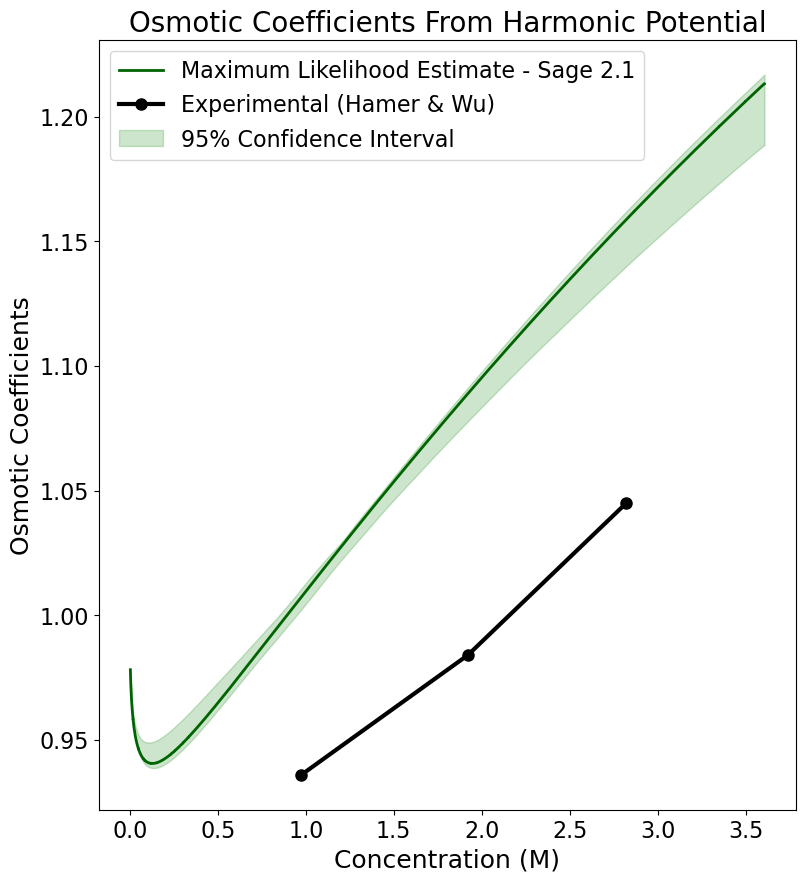

In [51]:
# Plot osmotic coefficients vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.plot(c_opt_sparse_all, opt_oc, lw=2, label='Maximum Likelihood Estimate - Sage 2.1', color='darkgreen')
plt.plot(xconc,yexpOC, marker='o', linestyle='-',color='k', label='Experimental (Hamer & Wu)', lw=3, markersize=8)
plt.fill_between(c_opt_sparse_all, lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Coefficients', fontsize=MEDIUM_SIZE)
plt.legend()
# plt.xlim(0.0,3.5)
# plt.ylim(0.92,1.22)
plt.title('Osmotic Coefficients From Harmonic Potential', fontsize=BIGGER_SIZE)
plt.savefig('oc.png')
plt.show()

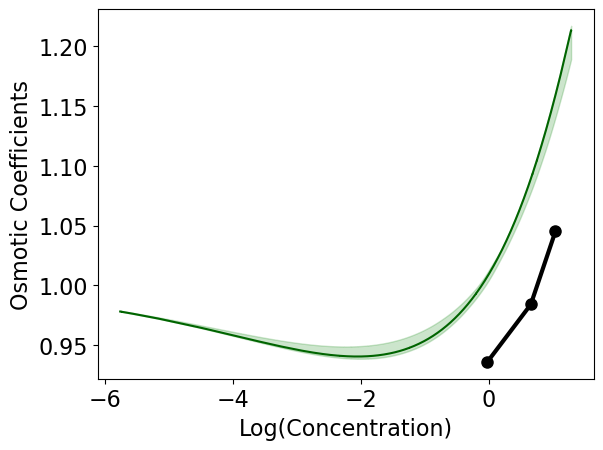

In [52]:
# plot osmotic coefficients vs ln of concentration
plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile', color='darkgreen')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound_95_oc, upper_bound_95_oc, color='g', alpha=0.2, label='95% Confidence Interval')
plt.plot(np.log(xconc),yexpOC, marker='o', linestyle='-',color='k', label='Experimental (Hamer & Wu)', lw=3, markersize=8)
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()

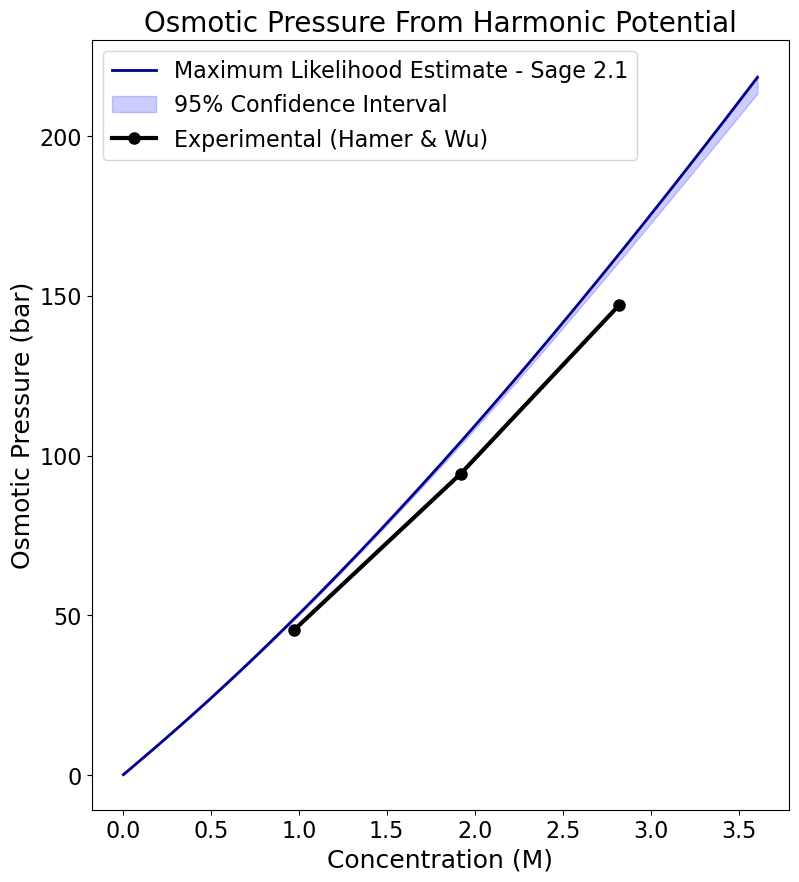

In [53]:
# Plot osmotic pressure vs concentration
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.plot(c_opt_sparse_all, opt_op, lw=2, label='Maximum Likelihood Estimate - Sage 2.1', color='darkblue')
plt.fill_between(c_opt_sparse_all, lower_bound_95_op, upper_bound_95_op, color='b', alpha=0.2, label='95% Confidence Interval')
plt.plot(xconc,yexpOP, marker='o', linestyle='-',color='k', label='Experimental (Hamer & Wu)', lw=3, markersize=8)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Pressure (bar)', fontsize=MEDIUM_SIZE)
plt.legend()
plt.title('Osmotic Pressure From Harmonic Potential', fontsize=BIGGER_SIZE)
plt.savefig('op.png')
plt.show()